In [7]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

Set up data for later

In [8]:
df=pd.read_csv('./resources/Sales_Data.csv', sep='\t', index_col=0)
df['purchase_date']= pd.to_datetime(df['purchase_date']) 
df = df[df['payment_amount']>100]
daily_sales = df.groupby(['purchase_date'])['payment_amount'].sum()
monthly_sales = daily_sales.resample('m').sum()
monthly_sales = pd.DataFrame(monthly_sales, columns=['payment_amount'])



In [9]:
monthly_sales.head()

,payment_amount
purchase_date,
2010-01-31,2378448.95
2010-02-28,1404627.65
2010-03-31,1581992.57
2010-04-30,1443978.55
2010-05-31,1406408.25


# Time Series Analysis: SARIMA Model


**Goal:** Students will be able to build and evaluate an ARIMA based model using ACF and PACF plots to choose the appropriate terms of the model.

**Agenda:**  
- Explain AR and MA terms
- Explain ACF and PACF charts
- Build an SARIMA Model

### Great Resources:

- https://newonlinecourses.science.psu.edu/stat510/lesson/1
- https://people.duke.edu/~rnau/411arim.htm

## Types of Models
There are two basic types of “time domain” models:

- Models that relate the present value of a series to past values and past prediction errors - these are called **ARIMA** models (for Autoregressive Integrated Moving Average). We’ll spend substantial time on these.
- Ordinary regression models that use time indices as x-variables. These can be helpful for an initial description of the data and form the basis of several simple forecasting methods.

### Running a linear regression model with stationary time series data

You can take your newly stationary data and use it as your target variable for a linear regression model. 

Making your data stationary tries to remove the correlation between serial time points. There still can be soem element of time that can explain changes in your target variable. A leap year, for example, will add an extra day for sales in February.  

1. How should we account for this in our linear regression model?
2. What are other time components that we might want to account for in a linear regression model? (think about other examples of hourly, daily, or weekly data)

***When performing a linear regression model on time series data, you need to eventually transformyour data back to the original scale***

### Reversing a first difference

In [10]:
#create a dataframe with random numbers
df_diff = pd.DataFrame({'A': np.random.randint(0, 10, 10)})
#create the first difference column
df_diff['B'] = df_diff['A'].diff()

#Reverse the first difference
x, x_diff = df_diff['A'].iloc[0], df_diff['B'].iloc[1:]
df_diff['C'] = np.r_[x, x_diff].cumsum().astype(int)

#view the data
df_diff

,A,B,C
0,8,NaN,8
1,8,0.0,8
2,2,-6.0,2
3,8,6.0,8
4,0,-8.0,0
5,4,4.0,4
6,6,2.0,6
7,9,3.0,9
8,6,-3.0,6
9,3,-3.0,3


## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>


# Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### Steps to creating an Arima model for time series data
![steps](./resources/flowchart.png)

# ACF and PACF
# Autocorrelation Function / Partial Autocorrelation Function
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.
 
<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, unbiased, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>
   
<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>


## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$



### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

# Plotting
The arrays returned by <tt>.acf(df)</tt> and <tt>.pacf_yw(df)</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the <strong>Airline Passengers</strong> dataset first.

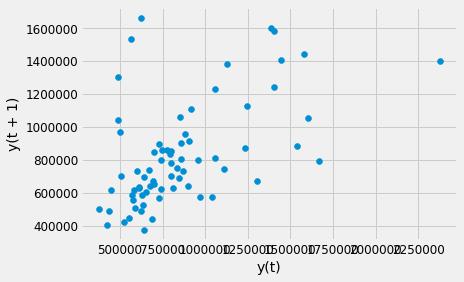

In [11]:
from pandas.plotting import lag_plot

lag_plot(monthly_sales['payment_amount']);

In [12]:
monthly_sales['first_difference'] = monthly_sales.payment_amount - monthly_sales.payment_amount.shift(1)  
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)  


## Plot ACF/PACF charts and find optimal parameters.

One we have achieved stationarity the next step in fitting a model to address any autocorrelation that remains in the differenced series.

### Autocorrelation Function ACF


The sample autocorrelation function (ACF) for a series gives correlations between the series and lagged values of the series for lags of 1, 2, 3, and so on. The lagged values can be written as $Y_{t-1}$, $Y_{t-2}$, $Y_{t-3}$ and so on. The ACF gives correlations between $Y_t$ and $Y_{t-1}$, $Y_t$ and $Y_{t-2}$, and so on.

The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

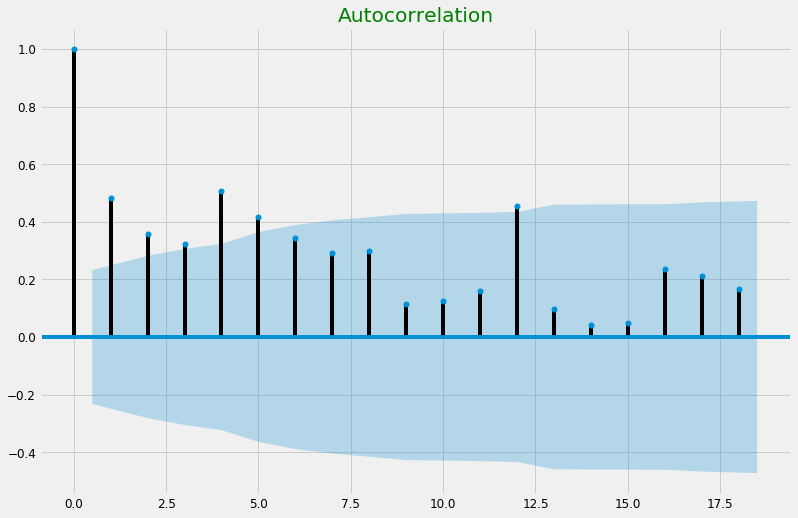

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)


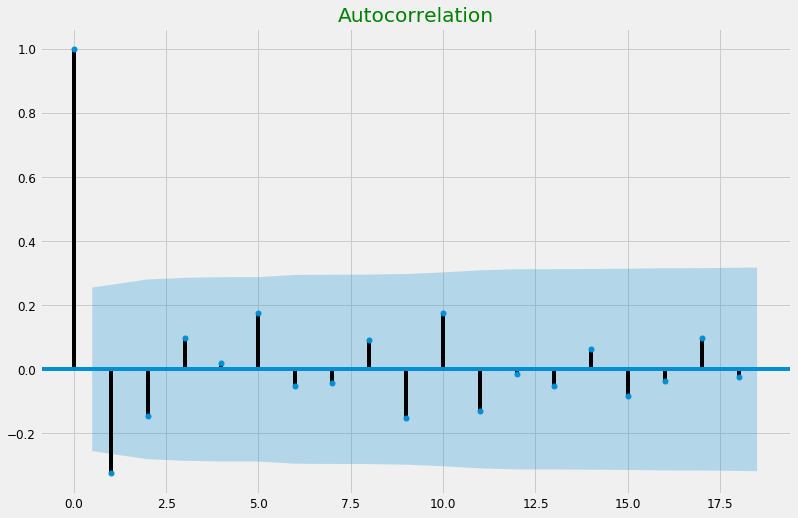

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.seasonal_first_difference.iloc[13:], lags=18, ax=ax1)

### Partial autocorrelation 

In general, a partial correlation is a conditional correlation. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. The autocorrelation of a time series $Y$ at lag 1 is the coefficient of correlation between $Y_t$ and $Y_{t-1}$, which is presumably also the correlation between $Y_{t-1}$ and $Y_{t-2}$. But if $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$. In fact, the amount of correlation we should expect at lag 2 is precisely the square of the lag-1 correlation. Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.


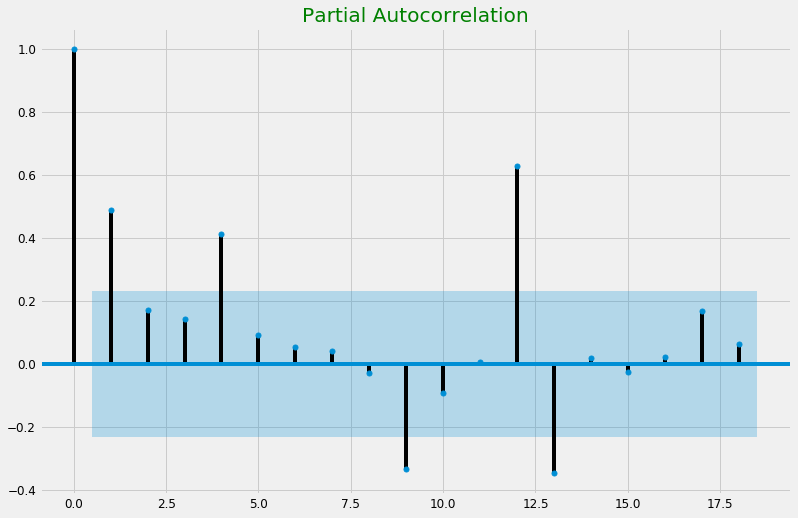

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)

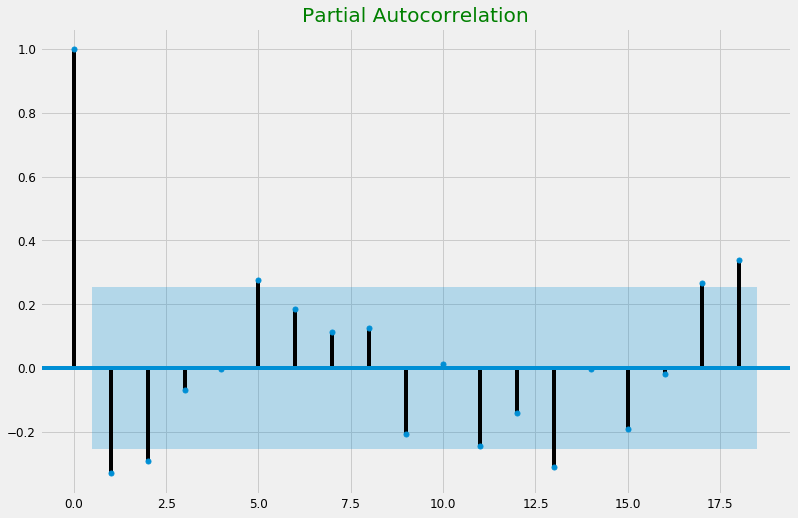

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.seasonal_first_difference.iloc[13:], lags=18, ax=ax1)

Why is this important? 

#### Determinging AR and MA terms

If after making your data stationary, there is still come autocorrelation between time periods, we can use that relationship to help predict future time periods.  



# AR(p)
# Autoregressive Model
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. In our example we forecasted numbers of airline passengers in thousands based on a set of level, trend and seasonal predictors.

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html'>ar_model.AR</a></strong><font color=black>(endog[, dates, freq, missing])</font>&nbsp;&nbsp;Autoregressive AR(p) model<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.html'>ar_model.ARResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an AR model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/AR.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive models</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive model</font></div>

In [17]:

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults


In [18]:
len(monthly_sales)

72

In [19]:
monthly_sales.head()

,payment_amount,first_difference,seasonal_first_difference
purchase_date,,,
2010-01-31,2378448.95,NaN,NaN
2010-02-28,1404627.65,-973821.30,NaN
2010-03-31,1581992.57,177364.92,NaN
2010-04-30,1443978.55,-138014.02,NaN
2010-05-31,1406408.25,-37570.30,NaN


## Evaluating a Time Series Model

Can we use test train split when evaluating this model? 

<img src='https://people.duke.edu/~rnau/randwkf2.gif' width=700 />

-  The data in the **estimation period** are used to help select the model and to estimate its parameters. Forecasts made in this period are not completely "honest" because data on both sides of each observation are used to help determine the forecast. 

- The data in the **validation period** are held out during parameter estimation, and if you are careful you will also withhold these values during the exploratory phase of analysis when you select your model. One-step-ahead forecasts made in this period are often called backtests. Ideally, these are "honest" forecasts, however, if you test a great number of models and choose the model whose errors are smallest in the validation period, you may end up overfitting the data within the validation period as well as in the estimation period.

- **Forecasts into the future** are "true" forecasts that are made for time periods beyond the end of the available data. For a model which is purely extrapolative in nature , it is possible to extend the forecasts an arbitrary number of periods into the future by "bootstrapping" the model: first a one-period-ahead forecast is made, then the one-period-ahead forecast is treated as a data point and the model is cranked ahead to produce a two-period-ahead forecast, and so on as far as you wish.

In [20]:
# Set one year for testing
train = monthly_sales['payment_amount'].iloc[:66]
test = monthly_sales['payment_amount'].iloc[66:]

In [21]:
# # Set one year for testing
# train = monthly_sales['seasonal_first_difference'].iloc[13:66]
# test = monthly_sales['seasonal_first_difference'].iloc[66:]

In [22]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
train

purchase_date
2010-01-31    2378448.95
2010-02-28    1404627.65
2010-03-31    1581992.57
2010-04-30    1443978.55
2010-05-31    1406408.25
2010-06-30    1244029.40
2010-07-31    1126584.87
2010-08-31    1383311.47
2010-09-30    1603297.97
2010-10-31    1055442.10
2010-11-30     808710.62
2010-12-31     625747.46
2011-01-31    1665684.28
2011-02-28     794816.26
2011-03-31     835580.77
2011-04-30     749086.50
2011-05-31     857573.74
2011-06-30     802480.99
2011-07-31     854560.15
2011-08-31    1059624.57
2011-09-30    1233573.86
2011-10-31     870453.75
2011-11-30     729238.63
2011-12-31     566393.59
2012-01-31    1537523.55
2012-02-29     882180.59
2012-03-31     955558.73
2012-04-30     801901.52
2012-05-31     778083.71
2012-06-30     857016.68
                 ...    
2013-01-31    1301365.94
2013-02-28     674002.86
2013-03-31     639206.89
2013-04-30     694277.15
2013-05-31     669357.28
2013-06-30     740570.43
2013-07-31     798993.52
2013-08-31     700943.75
2013-09-30 

In [24]:
model = AR(train)
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const                477123.377855
L1.payment_amount         0.478306
dtype: float64


In [25]:
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [26]:
predictions1

2015-07-31    778022.180833
2015-08-31    849256.161036
2015-09-30    883327.810871
2015-10-31    899624.490058
2015-11-30    907419.291712
2015-12-31    911147.593174
Freq: M, Name: AR(1) Predictions, dtype: float64

In [27]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test[i]}")

predicted=778022.1808, expected=585408.5
predicted=849256.161 , expected=614235.6300000001
predicted=883327.8109, expected=634805.91
predicted=899624.4901, expected=524765.27
predicted=907419.2917, expected=424525.49000000005
predicted=911147.5932, expected=401077.82999999996


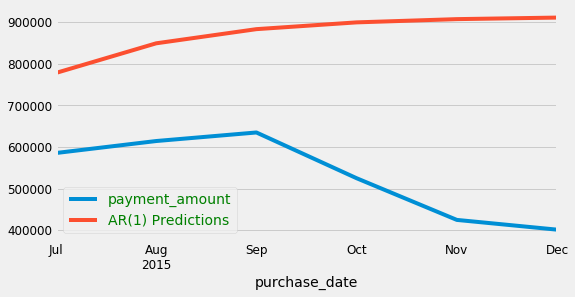

In [28]:
test.plot(legend=True)
predictions1.plot(legend=True,figsize=(8,4));

## Fit an AR(2) Model

In [29]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const                363814.781360
L1.payment_amount         0.364023
L2.payment_amount         0.246507
dtype: float64


In [30]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

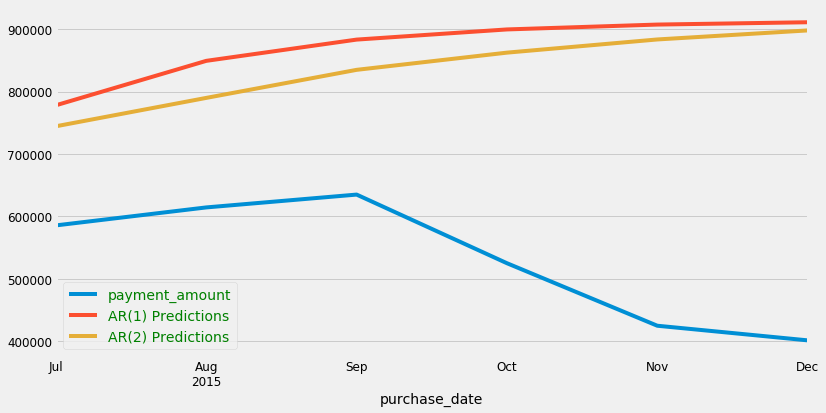

In [31]:
test.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## Fit an AR(p) model where statsmodels chooses p
This time we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [32]:
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 11
Coefficients:
const                 160217.641146
L1.payment_amount         -0.246131
L2.payment_amount         -0.045596
L3.payment_amount          0.141598
L4.payment_amount          0.576184
L5.payment_amount          0.653210
L6.payment_amount          0.502030
L7.payment_amount          0.368841
L8.payment_amount          0.176199
L9.payment_amount         -0.317955
L10.payment_amount        -0.439357
L11.payment_amount        -0.518991
dtype: float64


In [33]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

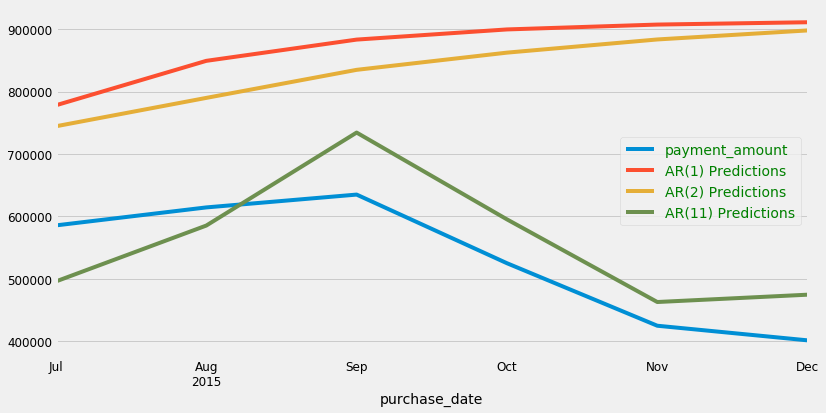

In [34]:
test.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## Evaluation Metrics
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [35]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test, preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 1.313291395e+11
AR(2) Error: 1.112980618e+11
AR(11) Error: 5.092224323e+09


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

### AIC / BIC
More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

but we seldom compute them alone as they are built into many of the statsmodels tools we use.

In [36]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 24.337
AR(2) AIC: 24.367
AR(11) AIC:  24.64


## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

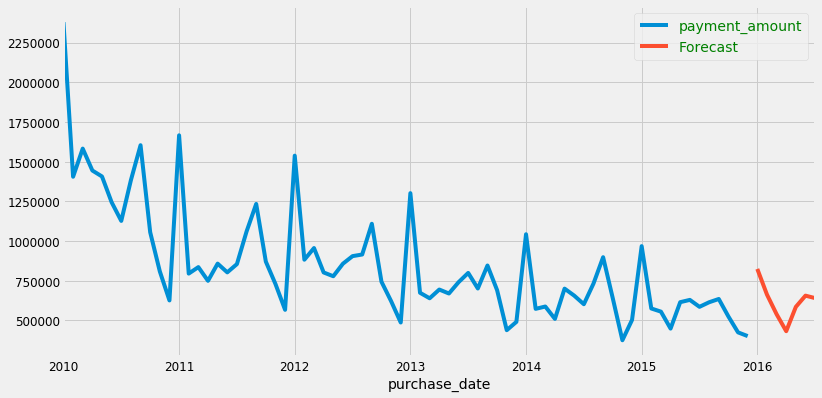

In [37]:
# First, retrain the model on the full dataset
model = AR(monthly_sales['payment_amount'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions
fcast = ARfit.predict(start=len(monthly_sales), end=len(monthly_sales)+6, dynamic=False).rename('Forecast')

# Plot the results
monthly_sales['payment_amount'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

### Autoregressive Integrated Moving Average  (ARIMA)

#### Autoregressive term

If the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant.  The forecasting equation in this case is:


$$Ŷ_t  =  μ  +  ϕ_{t-1}Y_{t-1}$$

…which is Y regressed on itself lagged by one period. 

### Integrated

Refers to the order of differencing used in the model. 

####  Moving Average term

Another strategy for correcting autocorrelated errors is to use an average of the last few observations in order to filter out the noise and more accurately estimate the local mean. One of which is the so-called “error correction” form, in which the previous forecast is adjusted in the direction of the error it made:

$$Ŷ_t   =  Ŷ_{t-1}  + αe_{t-1}$$  

Because $e_{t-1} = Y_{t-1} - Ŷ_{t-1}$ by definition, this can be rewritten as:

$$Ŷ_t   =  Y_{t-1}  - (1-α)e_{t-1}$$

$$Ŷ_t=  Y_{t-1}  - θ_1e_{t-1}$$




An ARIMA model is classified as an **ARIMA(p,d,q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms

# Seasonal ARIMA model with Exogenous Factors  (SARIMAX)

A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms
    
**Exogenous Factors** refers to any features that are not derived from the target variable.  

One way is just to run all combinations of options and see which one performs the best by some metric:

In [38]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))


Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (0, 1, 0, 12)
SARIMAX: (1, 1, 0) x (0, 1, 1, 12)
SARIMAX: (1, 1, 0) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (0, 1, 0, 12)
SARIMAX: (1, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 1) x (1, 1, 1, 12)


In [39]:
y = monthly_sales['payment_amount']

In [40]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1524.4534149930785
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1210.602051166244
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1238.0369790205784
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1212.0593494767272
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1489.7467971795493
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1164.440453947393
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1213.808670482702
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1164.029625530262
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1518.917752828626
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1201.8220256084944
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1201.873343840109
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1203.7958741080258
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1489.589500764431
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1166.2946974309355
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1189.9811095649065
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1165.7510089875316


A rule-of-thumb for this situation, which will be discussed in more detail later on, is that positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. 


![alt text](./resources/armaguidelines.png)

#### Rules for Indentifying ARIMA Models

https://people.duke.edu/~rnau/arimrule.htm

## ACF and PACF

#### Original Data

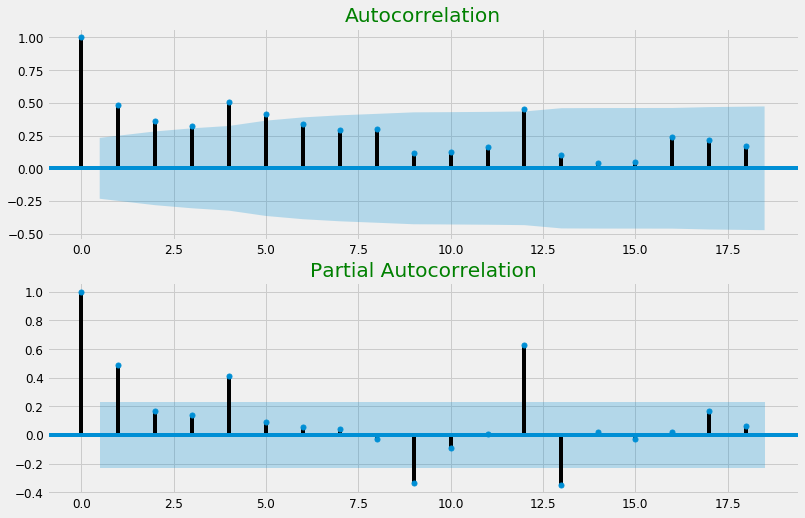

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax2)

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a first diefference of the data to remove this autocorrelation.

In [42]:
monthly_sales['first_difference'] = monthly_sales.payment_amount - monthly_sales.payment_amount.shift(1)  

#### First Difference

Now that we have taken a first difference, lets analyze the ACF and PACF plots again to see if there is more autocorrelation we need to account for.

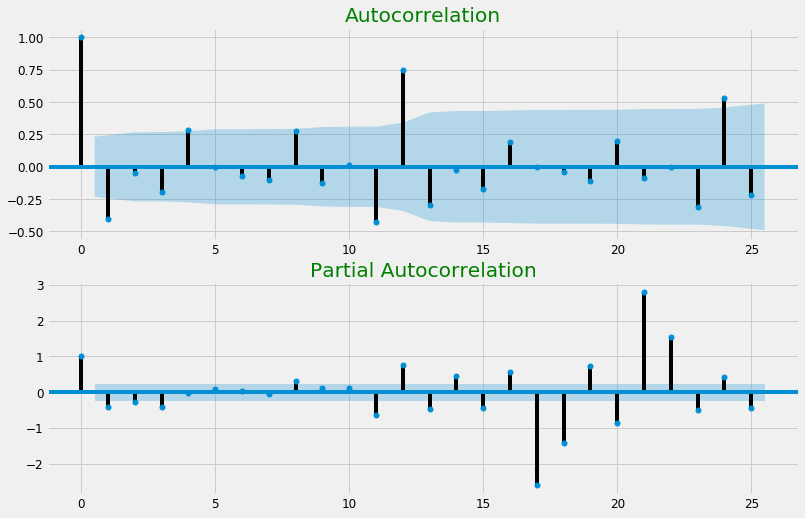

In [43]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.first_difference.iloc[1:], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.first_difference.iloc[1:], lags=25, ax=ax2)

Here we see ha huge autocorrelation and partial autocorrelation at lag 12 and 24. This is due to the seasonality of the data.  Therefore we should take a seasonal difference as well. 

In [44]:
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)  


#### Seasonal first difference

Now that we have taken both a seasonal and first diefference, let's revaluate our ACF and PACF plots to check for autocorrelation.

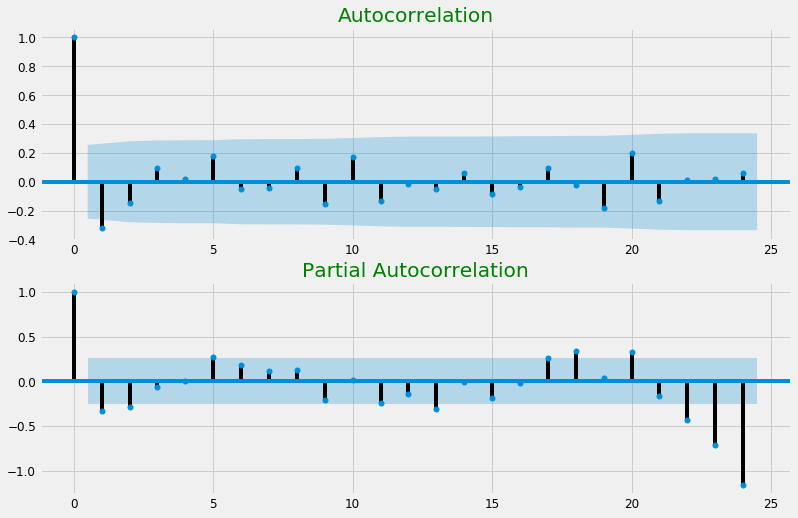

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax2)

Looking at these graphs, I see a significatn negative correlation at lags 1 and 13. This leads me to believe we should include one MA term and one SMA term in our model.

### Question

If you are trying to predict sales of grad school prep courses, what are some exogenous features you would want to include in your model?

### Estimating and Diagnosing a Possible Model
After you’ve made a guess (or two) at a possible model, use software such as R, Minitab, or SAS to estimate the coefficients. Most software will use maximum likelihood estimation methods to make the estimates. Once the model has been estimated, do the following.

- Look at the significance of the coefficients. In R, sarima provides p-values and so you may simply compare the p-value to the standard 0.05 cut-off. The arima command does not provide p-values and so you can calculate a t-statistic:  = estimated coeff. / std. error of coeff. Recall that  is the Student -value with area  to the right of  on df degrees of freedom. If , then the estimated coefficient is significantly different from 0. When n is large, you may compare estimated coeff. / std. error of coeff to 1.96.
- Look at the ACF of the residuals. For a good model, all autocorrelations for the residual series should be non-significant. If this isn’t the case, you need to try a different model.
- Look at Box-Pierce (Ljung) tests for possible residual autocorrelation at various lags (see Lesson 3.2 for a description of this test).
- If non-constant variance is a concern, look at a plot of residuals versus fits and/or a time series plot of the residuals.
If something looks wrong, you’ll have to revise your guess at what the model might be. This might involve adding parameters or re-interpreting the original ACF and PACF to possibly move in a different direction.

### What if More Than One Model Looks Okay?
Sometimes more than one model can seem to work for the same dataset. When that’s the case, some things you can do to decide between the models are:

- Possibly choose the model with the fewest parameters.
- Examine standard errors of forecast values. Pick the model with the generally lowest standard errors for predictions of the future.
- Compare models with regard to statistics such as the MSE (the estimate of the variance of the wt), AIC, AICc, and SIC (also called BIC). Lower values of these statistics are desirable.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

In [46]:
from pmdarima import auto_arima                              # for determining ARIMA orders


# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(monthly_sales['payment_amount'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(5, 1, 4)x(1, 0, 1, 12)   Log Likelihood                -933.169
Date:                            Thu, 19 Dec 2019   AIC                           1892.339
Time:                                    15:56:18   BIC                           1921.754
Sample:                                         0   HQIC                          1904.036
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.815e+04   1.58e+04     -1.778      0.075   -5.92e+04    2876.003
ar.L1         -0.5090      0.291     -1.750      0.080      -1.079       0.061
ar.L2          1.2228      0.191      6.395      0.000       0.848       1.598
ar.L3          0.0535      0.224      0.238      0.812      -0.386       0.494
ar.L4         -0.8640      0.220     -3.919      0.000      -1.296      -0.432
ar.L5         -0.1544      0.066     -2.329      0.020      -0.284      -0.024
ma.L1          0.2302      0.376      0.612      0.541      -0.507       0.968
ma.L2         -1.3999      0.300     -4.667      0.000      -1.988      -0.812
ma.L3          0.2876      0.390      0.737      0.461      -0.477       1.052
ma.L4          0.9627      0.404      2.380      0.017       0.170       1.755
ar.S.L12       0.7819      0.098      7.940      0.000       0.589       0.975
ma.S.L12      -0.3586      0.216     -1.657      0.098      -0.783       0.066
sigma2      2.235e+10      0.002   1.05e+13      0.000    2.24e+10    2.24e+10
===================================================================================
Ljung-Box (Q):                       38.98   Jarque-Bera (JB):                 2.85
Prob(Q):                              0.52   Prob(JB):                         0.24
Heteroskedasticity (H):               0.35   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+29. Standard errors may be unstable.
"""

## Fitting the Model

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [48]:
sm.tsa.statespace.SARIMAX()

TypeError: __init__() missing 1 required positional argument: 'endog'

In [49]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(5, 1, 4),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     payment_amount   No. Observations:                   66
Model:             SARIMAX(5, 1, 4)x(1, 0, 1, 12)   Log Likelihood                -621.197
Date:                            Fri, 20 Dec 2019   AIC                           1266.395
Time:                                    11:22:04   BIC                           1288.849
Sample:                                01-31-2010   HQIC                          1274.881
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0242      2.934      0.008      0.993      -5.726       5.774
ar.L2          0.5501      1.043   

In [50]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(5,1,4)(1,0,1,12) Predictions')

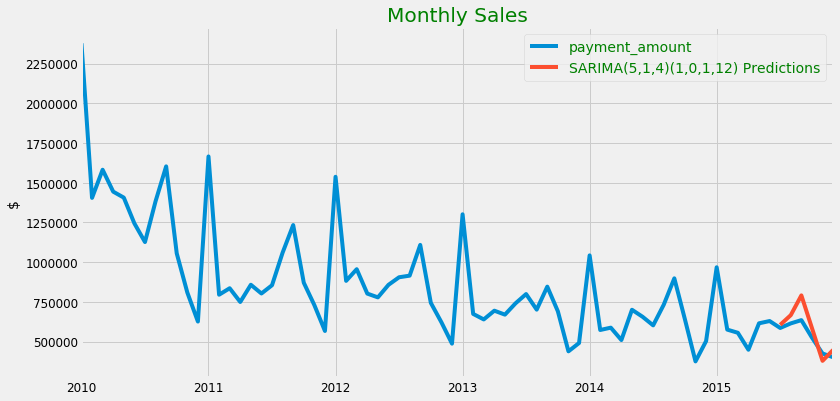

In [51]:
# Plot predictions against known values
title = 'Monthly Sales'
ylabel='$'
xlabel=''

ax = monthly_sales['payment_amount'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMA(5,1,4)(1,0,1,12) MSE Error: {error:11.10}')

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'SARIMA(5,1,4)(1,0,1,12) RMSE Error: {error:11.10}')

These are outstanding results!
### Retrain the model on the full data, and forecast the future

## Now let's predict all of 2016



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(monthly_sales['payment_amount'],order=(5,1,4),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(monthly_sales),len(monthly_sales)+11,typ='levels').rename('SARIMA(5,1,4)(1,0,1,12) Forecast')

In [ ]:
# Plot predictions against known values
title = 'Monthly Sales'
ylabel='$'
xlabel=''

ax = monthly_sales['payment_amount'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html